<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [1]:
!pip install --pre --quiet astroquery

     |████████████████████████████████| 4.3MB 3.4MB/s 
     |████████████████████████████████| 2.3MB 32.1MB/s 
     |████████████████████████████████| 61kB 24.2MB/s 
     |████████████████████████████████| 102kB 32.4MB/s 


In [69]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0-rc1


## Datos del SDSS

Disponible en enlace
### Consulta con astroquery



In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 1000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z,s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO' AND s.class !='GALAXY'
                      
                      """)

In [125]:
datapd=data.to_pandas()
print(datapd)

     fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0      21.54178    19.34560    17.99100    17.29384    16.89207        3858
1      19.50089    18.30866    18.17514    18.19209    18.22228        8500
2      19.58727    18.46065    17.96326    17.77162    17.64843        5621
3      23.99229    21.75072    20.37933    19.17858    18.47099        3717
4      18.99177    17.81833    17.68924    17.66101    17.69206        8500
5      18.60847    17.10279    16.49235    16.24145    16.14591        5426
6      21.45852    19.52747    18.60854    18.27136    18.10484        4752
7      22.12555    19.41456    17.92868    16.87359    16.33714        3717
8      20.54356    18.03133    16.93595    16.53442    16.29492        4382
9      17.84457    17.70756    18.01434    18.29773    18.59217        9000
10     17.49160    16.27623    16.04850    16.05326    16.08444        7071
11     19.73317    18.69365    18.54111    18.53421    18.59937        7500
12     20.68

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)


### Chequeo a los datos

Estadísticas:

In [127]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,800.0,20.125638,1.805079,15.83426,18.833650,19.896640,21.225237,25.97398
fiberMag_g,800.0,18.734785,1.585337,15.03552,17.733195,18.638445,19.542975,26.15056
fiberMag_r,800.0,18.185337,1.394225,14.62758,17.301417,18.032890,18.846958,23.35875
fiberMag_i,800.0,17.870358,1.278712,14.49856,17.019120,17.722935,18.674392,21.42054
fiberMag_z,800.0,17.704314,1.300767,14.11661,16.782490,17.582875,18.473330,21.48817


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
#norm train label
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [130]:

#normtest_temp=tf.keras.utils.normalize(test_labels,axis=0)
train_mean=train_labels.mean()
train_std=train_labels.std()


norm_train_labels=(train_labels-train_mean)/train_std
norm_train_feat = (train_feat - train_feat.mean())/train_feat.std()
print(norm_train_labels)

993   -1.240669
859    0.399802
298   -1.184101
553    0.714069
672   -1.349406
971    0.714069
27     1.971135
231    1.656868
306   -0.505914
706    0.085536
496    0.085536
558   -0.275243
784   -1.191015
239   -1.260782
578   -0.749785
55     1.028335
906    1.028335
175    0.085536
14     0.714069
77    -1.260782
31     0.714069
481    0.085536
310   -1.240669
311   -1.260782
883   -0.308555
788    0.936569
45     2.373396
103    0.399802
760   -0.931431
1      1.656868
         ...   
216    0.399802
735   -0.931431
129   -1.349406
349    0.798292
111    0.005712
166   -1.349406
207   -0.125023
438    1.123872
552    1.971135
274    0.399802
974    1.123872
591   -1.195415
800    1.123872
937   -0.308555
525    1.028335
287   -0.455632
469    1.656868
326   -0.542998
121   -1.184101
994    1.028335
507    0.085536
228   -1.366376
673   -1.195415
595   -0.931431
445    0.085536
117    1.249579
464    1.656868
25     1.971135
110    1.028335
149    2.536186
Name: elodieTEff, Length

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

### Estructura de la red neuronal

Modelo Secuencial

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    #layers.Dense(5, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

### Inspección del modelo

In [132]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [133]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo
  

Visualize the model's training progress using the stats stored in the `history` object.

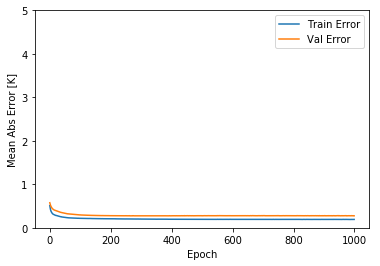

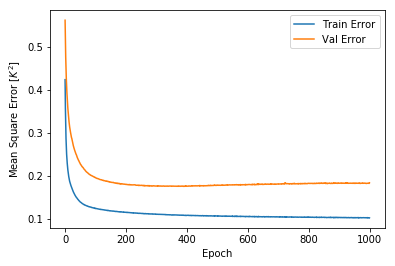

In [135]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [0]:
#model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history = model.fit(norm_train_feat, train_labels, epochs=EPOCHS,
#                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
#print(history)
#plot_history(history)

In [137]:
norm_test_feat = (test_feat-test_feat.mean())/test_feat.std()
norm_test_labels = (test_labels-test_labels.mean())/test_labels.std()


loss, mae, mse = model.evaluate(norm_test_feat, norm_test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error:  0.25


### Make predictions

Finally, predict Temperature values using data in the testing set:

(-679.1004480286738, 14261.10940860215, -625.0, 14315.209856630823)

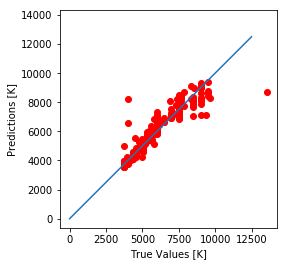

In [138]:
#print(norm_test_labels)

test_predictions = model.predict(norm_test_feat).flatten()
#print(test_predictions)

test_predictions = desnorm(test_predictions, train_mean, train_std)

plt.scatter(test_labels, test_predictions, color='red')
plt.plot([0 , 12500], [0, 12500])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

185.73557448387146


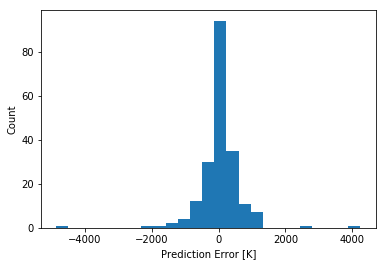

In [142]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

t_fin = time()

print(t_fin - t_ini)